In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sys, os
sys.path.insert(0, os.path.abspath('..'))
from scripts import project_functions

In [2]:
df = project_functions.load_and_process('FlamesData.csv')

In [3]:
total = len(df)
df['Intials'] = ""
for i in range(0,total) :
        intial = ""
        for c in df.iloc[i,0]:
            if c.isupper():
                intial = intial + c
        df.iloc[i,19] = intial

In [4]:
df['GoalsPerGame'] = df['G'] / df['GamesPlayed']

In [5]:
df['GoalsNorm'] = (df['G']-df['G'].min())/(df['G'].max()-df['G'].min())
df['GWGNorm'] = (df['GWG']-df['GWG'].min())/(df['GWG'].max()-df['GWG'].min())
df['PIMNorm'] = ((df['PenaltyMins']-df['PenaltyMins'].min())/(df['PenaltyMins'].max()-df['PenaltyMins'].min()))
df['PluMinNorm'] = (df['PlusMinus']-df['PlusMinus'].min())/(df['PlusMinus'].max()-df['PlusMinus'].min())
df['AvGPGNorm'] = (df['GoalsPerGame']-df['GoalsPerGame'].min())/(df['GoalsPerGame'].max()-df['GoalsPerGame'].min())

In [6]:
top20Goal = df.head(20)
top20Goal.head()

,Player,Hand,Pos,GamesPlayed,G,A,P,PlusMinus,PenaltyMins,P/GP,...,OTG,GWG,Shots,Intials,GoalsPerGame,GoalsNorm,GWGNorm,PIMNorm,PluMinNorm,AvGPGNorm
203,Jarome Iginla,R,R,1219.0,525.0,570.0,1095.0,46.0,831.0,0.90,...,6.0,83.0,3992.0,JI,0.430681,1.000000,1.000000,0.342248,0.339041,0.766865
130,Theo Fleury,R,R,791.0,364.0,466.0,830.0,148.0,1339.0,1.05,...,5.0,53.0,2685.0,TF,0.460177,0.692748,0.638554,0.554534,0.688356,0.820528
330,Joe Nieuwendyk,L,C,577.0,314.0,302.0,616.0,135.0,330.0,1.07,...,3.0,43.0,1549.0,JN,0.544194,0.597328,0.518072,0.132888,0.643836,0.973384
387,Gary Roberts,L,L,585.0,257.0,248.0,505.0,225.0,1736.0,0.86,...,3.0,27.0,1254.0,GR,0.439316,0.488550,0.325301,0.720435,0.952055,0.782575
332,Kent Nilsson,L,C,425.0,229.0,333.0,562.0,-34.0,90.0,1.32,...,1.0,25.0,1136.0,KN,0.538824,0.435115,0.301205,0.032595,0.065068,0.963613


# Explanation / Rational
In my EDA I was overwhelmed at first in deciding what to investigate and by the size of data I had, but then I reconsidered my research question. My reasearch question is to find who was the best player for the Calgary Flames. This could be interpretted in many ways but I took it to mean which player had the largest positive impact on the team. Breaking this down even further, creating a measure for positive impact on a team can't be boiled down to any one specific attribute, but rather a combination of many. However, the number of goals scored is the most important because games are won by goals, and thats the reason for trimming the player choice down to the top twenty goal scorers. As mentioned, there are some attributes which are more important than others, thus leading to weighting system. Below I will create the weighting system and organise hopefully be able to determine an answer.
The categories that will go towards the weighting system will be: 
1. goals
1. game winning goals
1. average goals per game
1. penalty minutes

Note, because we will be multiplying these attributes by a weighting factor and aggregating them we will use their nomalised data in order to have have an even comparison.

## Goals
As mentioned above, goals are considered the most important, however we have already isolated the top 20 goal scorers in the team. This means we have already accounted for a bit of the weight for this category so it won't have a strong weight in the aggregate. Also from the graph below we can see that there is not too much variance in the data so the weight for this will be low.

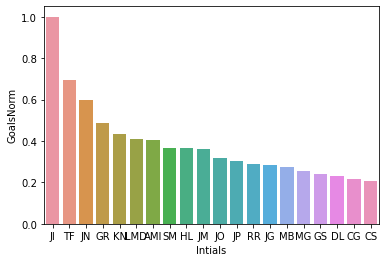

In [7]:
plotT20GG = sns.barplot(x='Intials', y='GoalsNorm', data = top20Goal)

In [8]:
GoalWeight = 0.1

## Game Winning Goals

Game winning goals are essentially a subset of the goals column. The reason they are included in the final analysis is because they are the most impactful goals in any winning game. The data for these demonstrates some higher variability and are important than just goals so they will get a much larger weight.

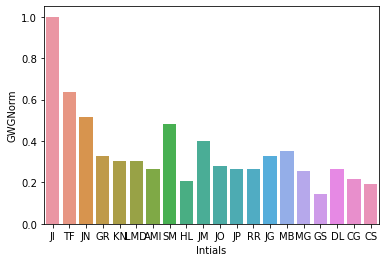

In [9]:
plotT20GGWG = sns.barplot(x='Intials', y='GWGNorm', data = top20Goal)

In [10]:
GWGWeight = 0.5

## Average Goals Per Game
Average goals per game is a metric that should represent the scoring consistency of each player. This is important when we think about positive impact of the player on a game by game level. Some players did not have the same time with the team and thus were not able to accrue as many goals. These types of players can still be very impactful on the team and this metric should demonstrate that. Because average goals per game filters out the effect of how many games were played and it demonstrates consistency, it will also receive a larger weighting.

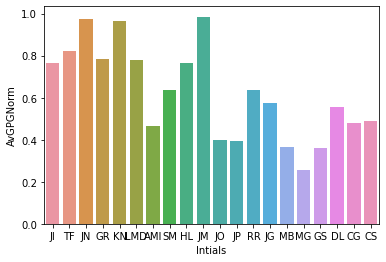

In [11]:
plotT20GGWG = sns.barplot(x='Intials', y='AvGPGNorm', data = top20Goal)

In [12]:
GPGWeight = 0.4

## Penalty Minutes
The penalty minutes column is a measure of the total amount of time that each player had to serve a penalty, thus putting a strain on the team. Because we see penalties as a bad thing, they will have a negative effect on the overall aggregation. However, using penalty minutes as bad thing is not always true because sometimes fighting can unite the team, demonstrate willingness to win, and provide protection for your fellow teammates. Because this is a more nuanced attribute its weight as negative will not be harsh.

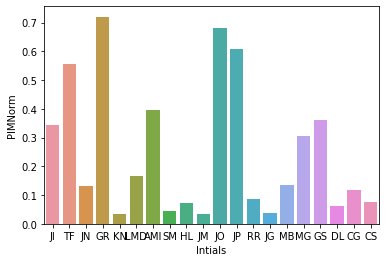

In [13]:
plotT20GPIM = sns.barplot(x='Intials', y='PIMNorm', data = top20Goal)

In [14]:
PIMWeight = 0.2

## Aggregation
Now to create and overall rating column using the formula:

rating = 0.1(Goals) + 0.5(Game Winning Goals) + 0.4(Goals Per Game) - 0.2(Penalty Minutes)

Note how the positive coefficeints sum to equal one. This means that the highest possible rating is one. The penalty minutes coeffecient of -0.2 is designed to take away from the rating of the player, however because we are dealing with a normalized set of data the person who has the least amount of penalty minutes in our top 20 goal scorers will have a normalized value of zero making it the smallest amount taken away from the rating. Inversly, the lowest possible score possible is -0.2. This score would only occur if a player in the top 20 goal scorers had the lowest amount of goals, game winning goals, average goals per game, and penalty minutes. In summary, the rating system is designed to rate the players on a scale of 1 to -0.2 based on their normalized attributes and the weighted equation above. 

In [15]:
Agg = pd.DataFrame()

In [16]:
Agg['Player'] = top20Goal['Player']
Agg['Intials'] = top20Goal['Intials']
Agg['Rating'] = (top20Goal['GoalsNorm']*0.1)+(top20Goal['GWGNorm']*0.5)+(top20Goal['AvGPGNorm']*0.4)-(top20Goal['PIMNorm']*0.2)
Agg = Agg.sort_values('Rating', ascending = False)

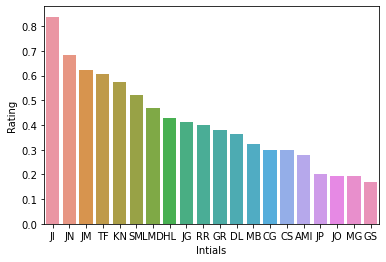

In [17]:
AggPlot = sns.barplot(x='Intials', y='Rating', data = Agg)

## Results
Form the plot we can see that the best player to play for the Calgary Flames is Jarome Iginla. This is not surprising he has long thought to be the best and its now confirmed through the above analysis. Below is a breakdown of Jarome Igninlas normalized stats.

In [18]:
data = [{'Attributes':'GoalsNorm' , 'Values':top20Goal.iloc[0, 21]}, {'Attributes':'GWGNorm' , 'Values':top20Goal.iloc[0, 22]}, {'Attributes':'AvGPGNorm' , 'Values':top20Goal.iloc[0, 20]} , {'Attributes':'PIMNorm' , 'Values':top20Goal.iloc[0, 24]}]
JI = pd.DataFrame(data)

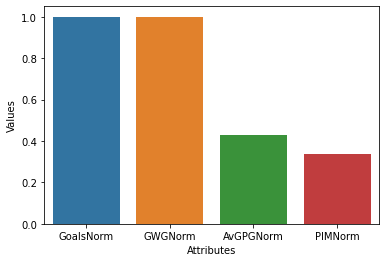

In [19]:
JIplot = sns.barplot(x='Attributes', y='Values', data = JI)

From the graph we can see that Jarome Iginla had the largest amount of goals and game winning goals. We can also see that he was about 40th percentile for goals per game and penalty mins for the top 20 goal scorers on the flames

In [20]:
df['Rating'] = (df['GoalsNorm']*0.1)+(df['GWGNorm']*0.5)+(df['AvGPGNorm']*0.4)-(df['PIMNorm']*0.2)
df.head()

,Player,Hand,Pos,GamesPlayed,G,A,P,PlusMinus,PenaltyMins,P/GP,...,GWG,Shots,Intials,GoalsPerGame,GoalsNorm,GWGNorm,PIMNorm,PluMinNorm,AvGPGNorm,Rating
203,Jarome Iginla,R,R,1219.0,525.0,570.0,1095.0,46.0,831.0,0.90,...,83.0,3992.0,JI,0.430681,1.000000,1.000000,0.342248,0.339041,0.766865,0.838296
130,Theo Fleury,R,R,791.0,364.0,466.0,830.0,148.0,1339.0,1.05,...,53.0,2685.0,TF,0.460177,0.692748,0.638554,0.554534,0.688356,0.820528,0.605856
330,Joe Nieuwendyk,L,C,577.0,314.0,302.0,616.0,135.0,330.0,1.07,...,43.0,1549.0,JN,0.544194,0.597328,0.518072,0.132888,0.643836,0.973384,0.681545
387,Gary Roberts,L,L,585.0,257.0,248.0,505.0,225.0,1736.0,0.86,...,27.0,1254.0,GR,0.439316,0.488550,0.325301,0.720435,0.952055,0.782575,0.380449
332,Kent Nilsson,L,C,425.0,229.0,333.0,562.0,-34.0,90.0,1.32,...,25.0,1136.0,KN,0.538824,0.435115,0.301205,0.032595,0.065068,0.963613,0.573040


### Further Question
What type of player is the best for scoring goals, in general? In other words, what type of player is most likely to impact a team positively? By type of player I mean what position do they play and which hand they shoot with.

This question could be something a new player just starting out would consider, or teams while drafting new players to their team. A note is that we are only going to use data from the Calgary Flames, however this analysis could be carried out for the entire league.

To answer this I will create a box plot of the distribution of goals by position and split by which way they shoot.

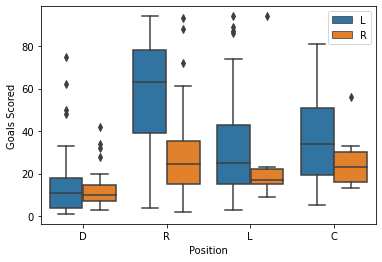

In [21]:
df2 = (df[df.Hand != '--']
       .sort_values(by = ['G'])
       .head(-25)
       .rename(columns={'Pos':'Position', 'G':'Goals Scored'})
      )
Vplot = sns.boxplot(x='Position', y='Goals Scored', hue='Hand', data = df2)
Vplot.legend(loc='upper right')

The above box plot helps demonstrate that left handed shooters playing right wing score the most goals, in general. This information could be used to help make a decision for a team that is looking for goal scorers. Note that Jarome Iginla, the best player to ever play for the flames was a right handed right wing player. This note helps illustrate that the plot above is only good for making generalizations about players and should not be used as the only reason for basing what position to play.

Now I am going to export 'df' as the processed data for presentation in seaborn.

In [23]:
df[df.Hand != '--'].to_csv(r'C:/Users/Jack Price/OneDrive/School/COSC.301/course-project-solo_117/data/processed/FlamesDataClean.csv', index=False)